# Task 2

In this class, we will develop a baseline for Task 2 using a subset of the lego dataset. We will model the task as an ordinal classification task.

In [121]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import pandas as pd
from dataclasses import dataclass

random.seed(42)

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Connect Colab to Drive (if the dataset is on drive)

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
!rm -rf /content/photos
!unzip "drive/MyDrive/photos_augmented_gen.zip"
!mv /content/photos_augmented_gen /content/photos

Archive:  drive/MyDrive/photos_augmented_gen.zip
   creating: photos_augmented_gen/
   creating: photos_augmented_gen/22/
  inflating: photos_augmented_gen/22/generated_22_2.jpg  
  inflating: photos_augmented_gen/22/generated_22_2_augmented_0.jpg  
  inflating: photos_augmented_gen/22/generated_22_2_augmented_1.jpg  
  inflating: photos_augmented_gen/22/generated_22_2_augmented_2.jpg  
  inflating: photos_augmented_gen/22/generated_22_1.jpg  
  inflating: photos_augmented_gen/22/generated_22_1_augmented_0.jpg  
  inflating: photos_augmented_gen/22/generated_22_1_augmented_1.jpg  
  inflating: photos_augmented_gen/22/generated_22_1_augmented_2.jpg  
   creating: photos_augmented_gen/15/
  inflating: photos_augmented_gen/15/IMG_20201127_003103.jpg  
  inflating: photos_augmented_gen/15/IMG_20201127_003103_augmented_0.jpg  
  inflating: photos_augmented_gen/15/IMG_20201127_003103_augmented_1.jpg  
  inflating: photos_augmented_gen/15/IMG_20201127_003103_augmented_2.jpg  
  inflating: pho

## Load dataset

In the Lego dataset, the images are organized into folders according to the number of legos. In this notebook, we will only consider images with up to 4 legos.

In [124]:
images_directory = "/content/photos"

# Obtain names of images for training and validation
image_paths = []
num_legos = []
for dirpath, dirnames, filenames in os.walk(images_directory):
    for filename in filenames:
        # Check how many legos the image has
        n = int(dirpath.split(os.sep)[-1])

        if filename.endswith('.jpg'):
            num_legos.append(n)
            image_paths.append(os.path.join(dirpath, filename))

image_paths = np.asarray(image_paths)
num_legos = torch.Tensor(num_legos).to(torch.int64)


# Use csv file to get the split
split_df = pd.read_csv("/content/drive/MyDrive/train_test_split.csv")
# Define the test has th paths that have column is_test = 1
split = np.zeros(len(image_paths))
for i, path in enumerate(image_paths):
    fodase_path = path
    if "generated" in path:
      continue # deal with these below
    if "augmented" in path:
      fodase_path = "_".join(path.split("_")[:-2]) + "." + path.split(".")[1]
    split[i] = int(split_df["/content/" + split_df["filename"] == fodase_path]["is_test"].values[0])
    if "augmented" in path and split[i] == 1:
      split[i] = -1

test_indexes = np.where(split == 1)[0]
train_indexes =  np.where(split == 0)[0]



num_legos_train = num_legos[train_indexes]
print(f"Train label distribution: {torch.bincount(num_legos_train)}")


# Get the train from the train/test csv split
img_indexes = train_indexes

############### Limit 1 and 2 classes ################
# get number of legos for each class 1,2,3,4
num_legos_train = num_legos[img_indexes]
# Get the indexes where num_legos is 1
one_lego_indexes = np.where(num_legos_train == 1)[0]
random.shuffle(one_lego_indexes)
one_lego_indexes = one_lego_indexes[:500]
img_indexes = np.concatenate((img_indexes[np.where(num_legos_train != 1)[0]], img_indexes[one_lego_indexes]))

# Get the indexes where num_legos is 2
num_legos_train = num_legos[img_indexes]
two_lego_indexes = np.where(num_legos_train == 2)[0]
random.shuffle(two_lego_indexes)
two_lego_indexes = two_lego_indexes[:220]
img_indexes = np.concatenate((img_indexes[np.where(num_legos_train != 2)[0]], img_indexes[two_lego_indexes]))
######################################################

num_legos_train = num_legos[img_indexes]
print(f"Train label distribution: {torch.bincount(num_legos_train)}")

#train_paths = split_df[split_df['is_test'] == 0]['filename'].tolist()
train_paths = [image_paths[x] for x in img_indexes]
print(len(train_paths))
print(train_paths[:10])

random.shuffle(train_paths)
train_img_paths = train_paths[:int(0.8*len(train_paths))]
valid_img_paths = train_paths[int(0.8*len(train_paths)):]

# Get all the augmented images for the train_img_indexes
split_tv = np.zeros(len(image_paths))
for i, path in enumerate(image_paths):
    #path = path[len("/content/"):]
    if "generated" in path:
      split_tv[i] = 1
    elif "augmented" in path:
      original_path = "_".join(path.split("_")[:-2]) + "." + path.split(".")[1]
      if original_path in train_img_paths:
          split_tv[i] = 1
    elif path in train_img_paths:
      split_tv[i] = 1
    elif path in valid_img_paths:
      split_tv[i] = 2



train_indexes = np.where(split_tv == 1)[0]
valid_indexes =  np.where(split_tv == 2)[0]


# print label distribution for train
num_legos_train = num_legos[train_indexes]
print(f"Train label distribution: {torch.bincount(num_legos_train)}")
bin_c = torch.bincount(num_legos_train)
for i in range(len(bin_c)):
  print(str(i), bin_c[i])

class_counts = bin_c.tolist()[1:]
print(class_counts)
print(len(class_counts))


# print relative size of each
total = len(train_indexes) + len(valid_indexes) + len(test_indexes)
print(f"Train size: {len(train_indexes)/total}")
print(f"Validation size: {len(valid_indexes)/total}")
print(f"Test size: {len(test_indexes)/total}")

"""
train_indexes.sort()
for ix in valid_indexes:
  original_path = "_".join(path.split("_")[:-2]) + "." + path.split(".")[1]
  print(ix, image_paths[ix])
  if "generated" in image_paths[ix]:
    print("XUXA XA XA XUXU XA")
  if original_path[len("/content/"):] not in train_img_paths:
    print("aaaaaaaaaaaaaaaaaaaaaaaa")
"""


Train label distribution: tensor([   0, 2177,  304,  118,   99,   64,   30,   42,   45,   42,   30,   35,
          27,   15,   28,   28,    8,   22,   24,    0,    8,    8,    8,   15,
          22,    8,    8,    8,   15,   23,   32,   15,   27])
Train label distribution: tensor([  0, 500, 220, 118,  99,  64,  30,  42,  45,  42,  30,  35,  27,  15,
         28,  28,   8,  22,  24,   0,   8,   8,   8,  15,  22,   8,   8,   8,
         15,  23,  32,  15,  27])
1574
['/content/photos/14/IMG_20201127_233812_augmented_2.jpg', '/content/photos/14/IMG_20201127_141325.jpg', '/content/photos/14/IMG_20201127_233812_augmented_1.jpg', '/content/photos/14/IMG_20201127_233812_augmented_5.jpg', '/content/photos/14/IMG_20201127_141315_augmented_5.jpg', '/content/photos/14/IMG_20201127_141315_augmented_2.jpg', '/content/photos/14/IMG_20201127_233812_augmented_0.jpg', '/content/photos/14/IMG_20201127_233719_augmented_5.jpg', '/content/photos/14/IMG_20201127_233719_augmented_3.jpg', '/content/photos/14

'\ntrain_indexes.sort()\nfor ix in valid_indexes:\n  original_path = "_".join(path.split("_")[:-2]) + "." + path.split(".")[1]\n  print(ix, image_paths[ix])\n  if "generated" in image_paths[ix]:\n    print("XUXA XA XA XUXU XA")\n  if original_path[len("/content/"):] not in train_img_paths:\n    print("aaaaaaaaaaaaaaaaaaaaaaaa")\n'

In [125]:
from PIL import Image


class LegosDataset(Dataset):
    def __init__(self, images_filenames, num_legos, transform=None):
        self.images_filenames = images_filenames
        self.transform = transform
        self.num_legos = num_legos

        # Transform number of legos into one hot encoding
        self.labels = num_legos - 1

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        label = self.labels[idx]

        # Read image
        image = cv2.imread(image_filename)

        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply the same data augmentation to both input image and target mask
        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [126]:
from torch.utils.data import DataLoader, WeightedRandomSampler

batch_size = 32
num_workers = 2

# Define transformations to be applied to data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.Resize((299, 299)), # This one is for inception
        transforms.Resize((224, 224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

# Calculate class weights based on the frequency of each class
def calculate_class_weights(labels):
    class_counts = torch.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / class_counts
    return class_weights

# Calculate sample weights based on the class weights
def calculate_sample_weights(labels, class_weights):
    sample_weights = class_weights[labels]
    return sample_weights

# Define datasets and dataloaders
train_dataset = LegosDataset(image_paths[train_indexes], num_legos[train_indexes], transform=transform)
valid_dataset = LegosDataset(image_paths[valid_indexes], num_legos[valid_indexes], transform=transform)
test_dataset = LegosDataset(image_paths[test_indexes], num_legos[test_indexes], transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=num_workers, shuffle=False)


# Calculate class weights and sample weights for the training dataset
train_labels = torch.tensor(train_dataset.labels)
class_weights = calculate_class_weights(train_labels)
sample_weights = calculate_sample_weights(train_labels, class_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=num_workers, shuffle=False)


<ipython-input-126-417bd92b3868>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_dataset.labels)


## Defining the model

Load a pre-trained convolutional neural network of your own choice from torchvision. Do not forget to change the last layer to match the number of classes (4)!

In [127]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
#model = models.inception_v3(pretrained=True)
#model.fc = nn.Linear(model.fc.in_features, 32)

MODEL = "vgg16"
#MODEL = "vgg16_bn"
#MODEL = "vgg19"
#MODEL = "vgg19_bn"
#MODEL = "inception_v3"
#MODEL = "resnet50"
#MODEL = "resnet18"
#MODEL = "lenet"

if MODEL == "inception_v3":
  from torchvision.models import inception_v3, Inception_V3_Weights

  # Step 1: Initialize model with the best available weights
  weights = Inception_V3_Weights.IMAGENET1K_V1
  model = inception_v3(weights=weights)
  model.eval()

  # Step 2: Initialize the inference transforms
  preprocess = weights.transforms()

  for param in model.parameters():
      param.requires_grad = False

  model.fc = nn.Linear(model.fc.in_features, 32)

elif MODEL == "vgg16":
  from torchvision.models import vgg16, VGG16_Weights

  # Step 1: Initialize model with the best available weights
  weights = VGG16_Weights.IMAGENET1K_V1
  model = vgg16(weights=weights)
  model.eval()

  # Step 2: Initialize the inference transforms
  preprocess = weights.transforms()

  for param in model.parameters():
      param.requires_grad = False

  # Newly created modules have require_grad=True by default
  num_features = model.classifier[6].in_features
  features = list(model.classifier.children())[:-1]  # Remove last layer
  model.classifier[6] = nn.Linear(num_features, 32)

elif MODEL == "vgg16_bn":
  from torchvision.models import vgg16_bn, VGG16_BN_Weights

  # Step 1: Initialize model with the best available weights
  weights = VGG16_BN_Weights.IMAGENET1K_V1
  model = vgg16_bn(weights=weights)
  model.eval()

  # Step 2: Initialize the inference transforms
  preprocess = weights.transforms()

  for param in model.parameters():
      param.requires_grad = False

  # Newly created modules have require_grad=True by default
  num_features = model.classifier[6].in_features
  features = list(model.classifier.children())[:-1]  # Remove last layer
  model.classifier[6] = nn.Linear(num_features, 32)

elif MODEL == "vgg19":
  from torchvision.models import vgg19, VGG19_Weights

  # Step 1: Initialize model with the best available weights
  weights = VGG19_Weights.IMAGENET1K_V1
  model = vgg19(weights=weights)
  model.eval()

  # Step 2: Initialize the inference transforms
  preprocess = weights.transforms()

  for param in model.parameters():
      param.requires_grad = False

  # Newly created modules have require_grad=True by default
  num_features = model.classifier[6].in_features
  features = list(model.classifier.children())[:-1]  # Remove last layer
  model.classifier[6] = nn.Linear(num_features, 32)

elif MODEL == "vgg19_bn":
  from torchvision.models import vgg19_bn, VGG19_BN_Weights

  # Step 1: Initialize model with the best available weights
  weights = VGG19_BN_Weights.IMAGENET1K_V1
  model = vgg19_bn(weights=weights)
  model.eval()

  # Step 2: Initialize the inference transforms
  preprocess = weights.transforms()

  for param in model.parameters():
      param.requires_grad = False

  # Newly created modules have require_grad=True by default
  num_features = model.classifier[6].in_features
  features = list(model.classifier.children())[:-1]  # Remove last layer
  model.classifier[6] = nn.Linear(num_features, 32)


elif MODEL == "resnet18":
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 32)

    # Freeze all layers except the last one
    for name, param in model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False

elif MODEL == "resnet50":
    from torchvision.models import resnet50, ResNet50_Weights
    weights = ResNet50_Weights.IMAGENET1K_V1
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 32)

    # Freeze all layers except the last one
    for name, param in model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False

elif MODEL == "lenet":
  from torchvision.models import googlenet, GoogLeNet_Weights

  # Step 1: Initialize model with the best available weights
  weights = GoogLeNet_Weights.IMAGENET1K_V1
  model = googlenet(weights=weights)
  model.eval()

  # Step 2: Initialize the inference transforms
  preprocess = weights.transforms()

  for param in model.parameters():
      param.requires_grad = False

  model.fc = nn.Linear(model.fc.in_features, 32)



model.to(device)
print(model)

Using cuda device


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Train the model

Define function to perform one iteration

In [128]:
@dataclass
class Result:
    loss: float
    accuracy: float
    balanced_accuracy: float
    precision: float
    recall: float
    f1: float

def step(model, dataloader, loss_fn, device, optimizer=None, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(images)
            # Transform InceptionOutputs to tensor
            if isinstance(outputs, torch.Tensor):
                outputs = outputs
            else:
                outputs = outputs.logits
            loss = loss_fn(outputs, labels)

            if is_train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.argmax(dim=1).detach().cpu().numpy())

    loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=0)

    return Result(
        loss,
        accuracy,
        balanced_accuracy,
        precision,
        recall,
        f1
    )



Define function to train a model

In [129]:
def train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, num_epochs):
    train_losses = []
    valid_losses = []
    valid_accuracies = []

    min_valid_loss = 0
    epoch_at_best = 0

    for epoch in range(num_epochs):
        train_result = step(model, train_dataloader, loss_fn, device, optimizer=optimizer, is_train=True)
        valid_result = step(model, valid_dataloader, loss_fn, device, is_train=False)

        print(f"Epoch {epoch + 1}/{num_epochs}")

        if CLASSIFICATION:
            print(f"{color.BOLD}Training{color.END}   Loss: {color.DARKCYAN}{train_result.loss:.4f}{color.END}, Accuracy: {color.DARKCYAN}{train_result.accuracy:.4f}{color.END}, Balanced Accuracy: {color.DARKCYAN}{train_result.balanced_accuracy:.4f}{color.END}, Precision: {color.DARKCYAN}{train_result.precision:.4f}{color.END}, Recall: {color.DARKCYAN}{train_result.recall:.4f}{color.END}, F1: {color.DARKCYAN}{train_result.f1:.4f}{color.END}")
            print(f"{color.BOLD}Validation{color.END} Loss: {color.DARKCYAN}{valid_result.loss:.4f}{color.END}, Accuracy: {color.DARKCYAN}{valid_result.accuracy:.4f}{color.END}, Balanced Accuracy: {color.DARKCYAN}{valid_result.balanced_accuracy:.4f}{color.END}, Precision: {color.DARKCYAN}{valid_result.precision:.4f}{color.END}, Recall: {color.DARKCYAN}{valid_result.recall:.4f}{color.END}, F1: {color.DARKCYAN}{valid_result.f1:.4f}{color.END}")
            train_history.loc[len(train_history)] = [train_result.loss, train_result.accuracy]
            val_history.loc[len(val_history)] = [valid_result.loss, valid_result.accuracy]

            valid_accuracies.append(valid_result.accuracy)
        else:
            print(f"{color.BOLD}Training{color.END}   Loss: {color.DARKCYAN}{train_result.loss:.4f}{color.END}, MAE: {color.DARKCYAN}{train_result.mae:.4f}{color.END}, MSE: {color.DARKCYAN}{train_result.mse:.4f}{color.END}, R2: {color.DARKCYAN}{train_result.r2:.4f}{color.END}")
            print(f"{color.BOLD}Validation{color.END} Loss: {color.DARKCYAN}{valid_result.loss:.4f}{color.END}, MAE: {color.DARKCYAN}{valid_result.mae:.4f}{color.END}, MSE: {color.DARKCYAN}{valid_result.mse:.4f}{color.END}, R2: {color.DARKCYAN}{valid_result.r2:.4f}{color.END}")
            train_history.loc[len(train_history)] = [train_result.loss, train_result.mae]
            val_history.loc[len(val_history)] = [valid_result.loss, valid_result.mae]

        if valid_result.loss < min_valid_loss:
            min_valid_loss = valid_result.loss
            torch.save(model.state_dict(), "current_best.pth")
            epoch_at_best = epoch

        train_losses.append(train_result.loss)
        valid_losses.append(valid_result.loss)

    print("Best model obtained at epoch ", epoch_at_best)
    return train_losses, valid_losses, valid_accuracies if CLASSIFICATION else None


Define loss, optimizer and train the model. Remember that we will model this regression task problem as a classification problem when choosing the loss function!

In [130]:
## Run to reset histories!!
train_history = pd.DataFrame(columns=['loss', 'accuracy'])
val_history = pd.DataFrame(columns=['loss', 'accuracy'])

In [131]:
## Change learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [104]:
# <<---------
### Atençao nao correr isto!


model.load_state_dict(torch.load('current_best.pth'))
"""
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier[6].parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "fc" in name:
        param.requires_grad = True
        """


'\nfor param in model.parameters():\n    param.requires_grad = False\n\nfor param in model.classifier[6].parameters():\n    param.requires_grad = True\n\nfor name, param in model.named_parameters():\n    if "fc" in name:\n        param.requires_grad = True\n        '

In [132]:
# Adjust loss to class imbalance
"""
import math
total_samples = sum(class_counts)/3
class_weights = [100 if class_count==0 else total_samples/(math.sqrt(class_count * 2)) for class_count in class_counts]
class_weights = [1, 2] + [4] * 30
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print(class_weights_tensor)

# Create loss function with class weights
class_weights_tensor = class_weights_tensor.to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
"""
loss_fn = nn.CrossEntropyLoss()


num_epochs = 20

print(f"Train size: {len(train_dataloader.dataset)}")

# Train the model

train_losses, valid_losses, valid_accuracies = train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, num_epochs)

torch.save(model.state_dict(), "/content/recent.pth")


Train size: 1284


100%|██████████| 6/6 [00:01<00:00,  5.47it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 1/20
Training   Loss: 1.9726, Accuracy: 0.4821, Balanced Accuracy: 0.4740, Precision: 0.5060, Recall: 0.4821, F1: 0.4760
Validation Loss: 1.7511, Accuracy: 0.5543, Balanced Accuracy: 0.3373, Precision: 0.6557, Recall: 0.5543, F1: 0.5789


100%|██████████| 6/6 [00:01<00:00,  4.47it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 2/20
Training   Loss: 0.8395, Accuracy: 0.7780, Balanced Accuracy: 0.7839, Precision: 0.7761, Recall: 0.7780, F1: 0.7729
Validation Loss: 1.7691, Accuracy: 0.4800, Balanced Accuracy: 0.3436, Precision: 0.7403, Recall: 0.4800, F1: 0.5537


100%|██████████| 6/6 [00:01<00:00,  5.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 3/20
Training   Loss: 0.5817, Accuracy: 0.8614, Balanced Accuracy: 0.8648, Precision: 0.8593, Recall: 0.8614, F1: 0.8582
Validation Loss: 1.7191, Accuracy: 0.4457, Balanced Accuracy: 0.3475, Precision: 0.6673, Recall: 0.4457, F1: 0.5129


100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 4/20
Training   Loss: 0.4121, Accuracy: 0.9081, Balanced Accuracy: 0.9067, Precision: 0.9083, Recall: 0.9081, F1: 0.9072
Validation Loss: 1.7206, Accuracy: 0.5257, Balanced Accuracy: 0.4128, Precision: 0.6656, Recall: 0.5257, F1: 0.5763


100%|██████████| 6/6 [00:01<00:00,  5.43it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 5/20
Training   Loss: 0.3308, Accuracy: 0.9245, Balanced Accuracy: 0.9245, Precision: 0.9230, Recall: 0.9245, F1: 0.9231
Validation Loss: 1.5694, Accuracy: 0.5657, Balanced Accuracy: 0.4556, Precision: 0.6992, Recall: 0.5657, F1: 0.6154


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 6/20
Training   Loss: 0.3029, Accuracy: 0.9322, Balanced Accuracy: 0.9308, Precision: 0.9313, Recall: 0.9322, F1: 0.9311
Validation Loss: 1.5087, Accuracy: 0.5600, Balanced Accuracy: 0.3850, Precision: 0.6843, Recall: 0.5600, F1: 0.6002


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 7/20
Training   Loss: 0.2790, Accuracy: 0.9229, Balanced Accuracy: 0.9281, Precision: 0.9203, Recall: 0.9229, F1: 0.9210
Validation Loss: 1.5934, Accuracy: 0.5543, Balanced Accuracy: 0.4408, Precision: 0.7098, Recall: 0.5543, F1: 0.5888


100%|██████████| 6/6 [00:01<00:00,  5.42it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 8/20
Training   Loss: 0.1891, Accuracy: 0.9579, Balanced Accuracy: 0.9498, Precision: 0.9567, Recall: 0.9579, F1: 0.9570
Validation Loss: 1.6299, Accuracy: 0.5771, Balanced Accuracy: 0.4436, Precision: 0.7458, Recall: 0.5771, F1: 0.6335


100%|██████████| 6/6 [00:01<00:00,  4.55it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 9/20
Training   Loss: 0.2057, Accuracy: 0.9424, Balanced Accuracy: 0.9420, Precision: 0.9420, Recall: 0.9424, F1: 0.9415
Validation Loss: 1.5033, Accuracy: 0.5829, Balanced Accuracy: 0.4279, Precision: 0.7061, Recall: 0.5829, F1: 0.6169


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 10/20
Training   Loss: 0.1636, Accuracy: 0.9626, Balanced Accuracy: 0.9614, Precision: 0.9625, Recall: 0.9626, F1: 0.9624
Validation Loss: 1.7176, Accuracy: 0.4629, Balanced Accuracy: 0.4375, Precision: 0.7024, Recall: 0.4629, F1: 0.5025


100%|██████████| 6/6 [00:01<00:00,  5.46it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 11/20
Training   Loss: 0.1989, Accuracy: 0.9486, Balanced Accuracy: 0.9499, Precision: 0.9475, Recall: 0.9486, F1: 0.9478
Validation Loss: 1.7531, Accuracy: 0.4686, Balanced Accuracy: 0.4238, Precision: 0.7148, Recall: 0.4686, F1: 0.4917


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 12/20
Training   Loss: 0.1621, Accuracy: 0.9564, Balanced Accuracy: 0.9572, Precision: 0.9572, Recall: 0.9564, F1: 0.9564
Validation Loss: 1.4562, Accuracy: 0.6000, Balanced Accuracy: 0.4298, Precision: 0.7132, Recall: 0.6000, F1: 0.6427


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 13/20
Training   Loss: 0.1539, Accuracy: 0.9564, Balanced Accuracy: 0.9563, Precision: 0.9565, Recall: 0.9564, F1: 0.9558
Validation Loss: 1.4318, Accuracy: 0.6400, Balanced Accuracy: 0.4749, Precision: 0.7119, Recall: 0.6400, F1: 0.6635


100%|██████████| 6/6 [00:01<00:00,  5.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 14/20
Training   Loss: 0.1434, Accuracy: 0.9587, Balanced Accuracy: 0.9602, Precision: 0.9591, Recall: 0.9587, F1: 0.9582
Validation Loss: 1.6783, Accuracy: 0.5657, Balanced Accuracy: 0.4859, Precision: 0.7120, Recall: 0.5657, F1: 0.6151


100%|██████████| 6/6 [00:01<00:00,  4.48it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 15/20
Training   Loss: 0.1366, Accuracy: 0.9673, Balanced Accuracy: 0.9670, Precision: 0.9665, Recall: 0.9673, F1: 0.9666
Validation Loss: 1.5015, Accuracy: 0.6343, Balanced Accuracy: 0.4595, Precision: 0.6929, Recall: 0.6343, F1: 0.6519


100%|██████████| 6/6 [00:01<00:00,  5.43it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 16/20
Training   Loss: 0.1235, Accuracy: 0.9681, Balanced Accuracy: 0.9674, Precision: 0.9678, Recall: 0.9681, F1: 0.9677
Validation Loss: 1.5650, Accuracy: 0.6171, Balanced Accuracy: 0.4908, Precision: 0.7348, Recall: 0.6171, F1: 0.6593


100%|██████████| 6/6 [00:01<00:00,  4.51it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 17/20
Training   Loss: 0.1392, Accuracy: 0.9626, Balanced Accuracy: 0.9637, Precision: 0.9625, Recall: 0.9626, F1: 0.9623
Validation Loss: 1.4456, Accuracy: 0.6400, Balanced Accuracy: 0.4592, Precision: 0.6941, Recall: 0.6400, F1: 0.6557


100%|██████████| 6/6 [00:01<00:00,  5.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 18/20
Training   Loss: 0.1263, Accuracy: 0.9681, Balanced Accuracy: 0.9641, Precision: 0.9676, Recall: 0.9681, F1: 0.9675
Validation Loss: 1.5606, Accuracy: 0.5829, Balanced Accuracy: 0.4423, Precision: 0.7032, Recall: 0.5829, F1: 0.6193


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 19/20
Training   Loss: 0.1087, Accuracy: 0.9712, Balanced Accuracy: 0.9680, Precision: 0.9714, Recall: 0.9712, F1: 0.9710
Validation Loss: 1.6291, Accuracy: 0.5886, Balanced Accuracy: 0.4408, Precision: 0.7168, Recall: 0.5886, F1: 0.6368


100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 20/20
Training   Loss: 0.1042, Accuracy: 0.9696, Balanced Accuracy: 0.9699, Precision: 0.9694, Recall: 0.9696, F1: 0.9694
Validation Loss: 1.5853, Accuracy: 0.6000, Balanced Accuracy: 0.4435, Precision: 0.7118, Recall: 0.6000, F1: 0.6374


In [ ]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

num_epochs = 10

# Train the model
train_losses, valid_losses, valid_accuracies = train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, num_epochs)

torch.save(model.state_dict(), "recent_after.pth")

100%|██████████| 6/6 [00:01<00:00,  5.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 1/10
Training   Loss: 8.9155, Accuracy: 0.0615, Balanced Accuracy: 0.0594, Precision: 0.0857, Recall: 0.0615, F1: 0.0611
Validation Loss: 3.4707, Accuracy: 0.0000, Balanced Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


100%|██████████| 6/6 [00:01<00:00,  4.99it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 2/10
Training   Loss: 3.4597, Accuracy: 0.0382, Balanced Accuracy: 0.0317, Precision: 0.0161, Recall: 0.0382, F1: 0.0174
Validation Loss: 3.5266, Accuracy: 0.0000, Balanced Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


Epoch 3/10
Training   Loss: 3.4404, Accuracy: 0.0296, Balanced Accuracy: 0.0283, Precision: 0.0200, Recall: 0.0296, F1: 0.0181
Validation Loss: 3.5564, Accuracy: 0.0057, Balanced Accuracy: 0.0769, Precision: 0.0000, Recall: 0.0057, F1: 0.0001


100%|██████████| 6/6 [00:01<00:00,  5.55it/s]


Epoch 4/10
Training   Loss: 3.4172, Accuracy: 0.0374, Balanced Accuracy: 0.0364, Precision: 0.0184, Recall: 0.0374, F1: 0.0209
Validation Loss: 3.3256, Accuracy: 0.2400, Balanced Accuracy: 0.0769, Precision: 0.0576, Recall: 0.2400, F1: 0.0929


 93%|█████████▎| 38/41 [00:17<00:01,  2.20it/s]

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [63]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

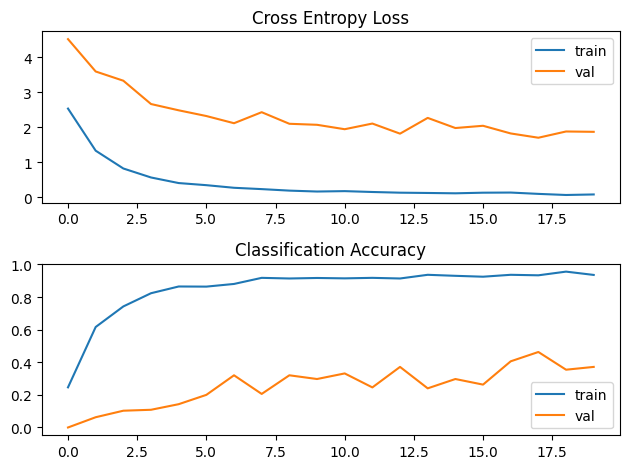

In [84]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

100%|██████████| 274/274 [00:03<00:00, 89.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Loss: 3.4205, Accuracy: 0.0985, Balanced Accuracy: 0.1268, Precision: 0.7201, Recall: 0.0985, F1: 0.0853


100%|██████████| 274/274 [00:02<00:00, 131.47it/s]


guessed  3
[13, 5, 17, 17, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 24, 25, 6, 7, 15, 26, 26, 26, 19, 9, 9]
[ 0  1  2  3  4  5  6  7  9 13 14 15 17 19 24 25 26]
lskdjfs [ 1  2  3  4  5  6  7  8 10 12 14 15 16 18 20 24 25 26 27 29 30]
[ 0  1  2  3  4  5  6  7  9 

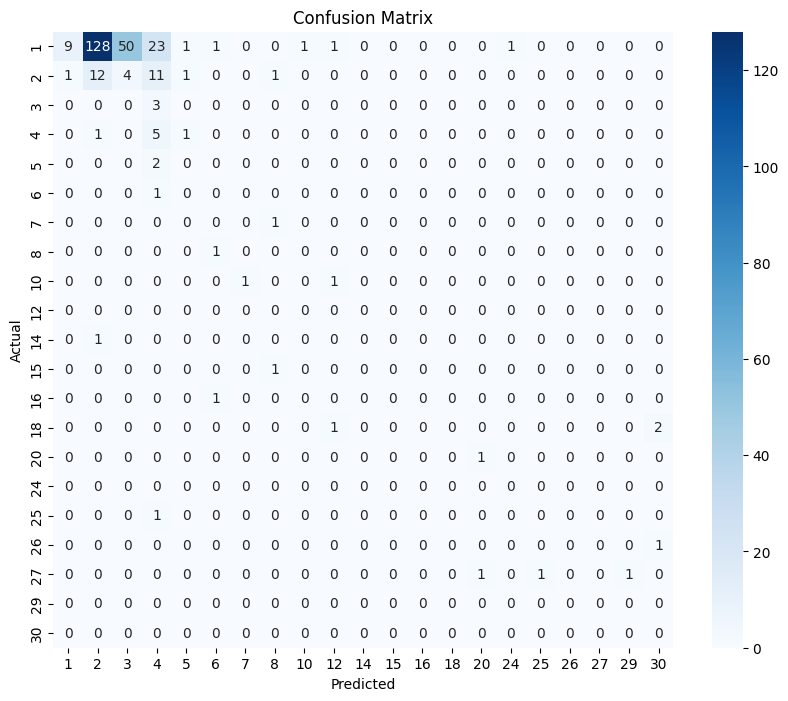

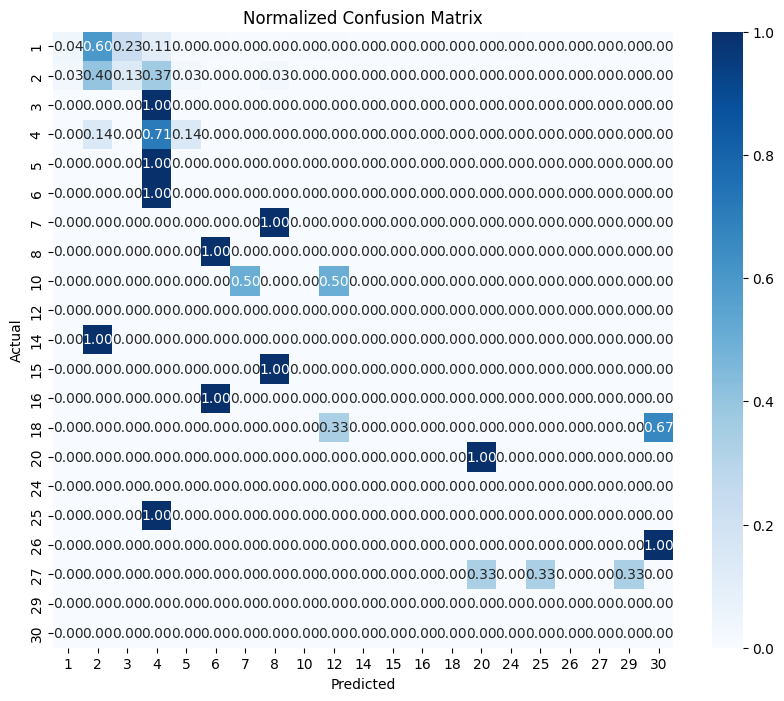

In [120]:
# Load the best model
# model.load_state_dict(torch.load("/content/recent_after.pth"))

# Evaluate model on test data
test_result = step(model, test_dataloader, loss_fn, device, is_train=False, is_regression_test_esparguete=not CLASSIFICATION)
print(f"Test Loss: {test_result.loss:.4f}")
if CLASSIFICATION:
    print(f"Accuracy: {test_result.accuracy:.4f}, Balanced Accuracy: {test_result.balanced_accuracy:.4f}, Precision: {test_result.precision:.4f}, Recall: {test_result.recall:.4f}, F1: {test_result.f1:.4f}")
else:
    print(f"MAE: {test_result.mae:.4f}, MSE: {test_result.mse:.4f}, R2: {test_result.r2:.4f}")

# If classification task, plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

all_labels = []
all_predictions = []

for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)

    if CLASSIFICATION:
        # For classification tasks
        predictions = outputs.argmax(dim=1).cpu().numpy()
        pred_labels = np.unique(np.union1d(all_labels, all_predictions)) + 1
    else:
        # For regression tasks
        if torch.is_tensor(outputs):  # Check if outputs is a tensor
            predictions = outputs.squeeze().cpu().numpy()
        else:  # If outputs is scalar, convert it into a single-element numpy array
            predictions = np.array([outputs.item()])

    all_predictions.append(predictions)

    all_labels.extend(labels.cpu().numpy())



####### vizualistaionskj
if not CLASSIFICATION:
    print(all_labels)
    grounded_predictions = [min(32, max(1, int(round(x.item())))) for x in all_predictions]
    print(grounded_predictions)
    # Assuming all_labels and all_predictions contain the actual and predicted values respectively
    plt.figure(figsize=(8, 6))
    plt.scatter(all_labels, all_predictions, color='blue', alpha=0.5)
    plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red')  # Identity line
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    all_predictions = grounded_predictions

    accuracy = accuracy_score(all_labels, all_predictions)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=0)

    print(f"Accuracy: {accuracy:.4f}, Balanced Accuracy: {balanced_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pred_labels, yticklabels=pred_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

cm = confusion_matrix(all_labels, all_predictions, normalize="true")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=pred_labels, yticklabels=pred_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!